# <font color='rosybrown'> Examen 4
## <font color='rosybrown'> Arantza Gomez Haro Gamboa

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
import lightgbm as lgb
import shap

In [2]:
def calibracion_multiple(modelos, y, bins):
    for nombre, predicciones in modelos.items():
        df_calibracion = pd.DataFrame({
            'predicciones': predicciones,
            'y': y
        })
        
        df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False, duplicates='drop') + 1
        grouped = df_calibracion.groupby('bins').mean()
        
        plt.figure()
    
        plt.plot(grouped.predicciones, grouped.y, label=f"{nombre} (Modelo)", marker="o", color="rosybrown")
        plt.plot(grouped.predicciones, grouped.predicciones, label="Real", marker="o", color="cornflowerblue")
        
        plt.grid()
        plt.legend()
        plt.xlabel("Predicción")
        plt.ylabel("Real")
        plt.title(f"Calibración para {nombre}")

## <font color='cornflowerblue'> Datos

In [3]:
df = pd.read_csv('hr_role.csv')
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})
df = pd.get_dummies(df)

target = 'Attrition'
y = df[target]
X = df.copy()
X = X.drop(target, axis = 1)

## <font color='cornflowerblue'> PCA

In [4]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA())
])

pipeline.fit(X)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA())])

In [5]:
objeto_pca = pipeline.named_steps['pca']
X_pca = pipeline.transform(X)
x_components = pd.DataFrame(X_pca,index=X.index, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
x_components.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53
0,-0.030304,-2.330446,-1.161395,3.217517,-0.113925,0.253495,-1.040500,0.309246,-0.448044,2.111620,...,0.014891,1.531962e-15,2.086084e-15,6.192959e-17,4.532546e-16,-5.432506e-16,-1.944498e-32,-6.963223e-16,-4.254345e-16,-6.085001e-16
1,0.049651,1.543678,-0.213908,-1.662470,0.719564,-2.208041,1.095471,-1.080794,2.427347,1.248215,...,-0.102855,-2.571133e-16,1.024939e-15,-1.555732e-15,-1.219919e-16,4.310296e-16,6.783304e-32,2.361651e-15,-5.550595e-16,3.965348e-16
2,-2.921983,0.996320,-0.206778,1.584724,-0.095803,0.098296,-2.782596,0.838934,0.416457,-0.642975,...,-0.099216,1.573595e-15,-6.270238e-16,2.007075e-16,7.308103e-16,4.004389e-16,1.136990e-32,-5.100518e-17,-9.236764e-17,-6.085001e-16
3,-1.187400,1.054261,-0.692836,2.306721,-0.228501,-2.392424,1.058589,-0.071526,-1.843889,1.818120,...,0.045951,-7.856287e-16,-4.327348e-16,-8.574739e-16,-1.139222e-15,-3.212060e-16,4.526627e-32,1.302079e-15,-4.254345e-16,2.796783e-16
4,-2.122667,1.196360,0.532758,-1.288092,-0.694017,1.685820,-0.501539,0.272690,-0.631277,-1.714992,...,0.148985,-4.236468e-16,-8.901959e-16,-4.177530e-16,-4.828144e-16,-7.902157e-16,1.852923e-32,3.018256e-17,2.498522e-16,5.075571e-16


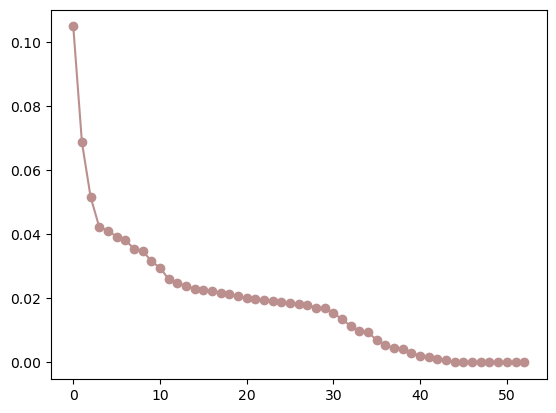

In [6]:
plt.plot(objeto_pca.explained_variance_ratio_, marker='o', color = 'rosybrown')

#### <font color='cornflowerblue'> Análisis:

## <font color='cornflowerblue'> Modelo KMeans

### <font color='cornflowerblue'> Gráfica del codo

c:\Users\arant\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\arant\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\arant\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\arant\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

Text(0, 0.5, 'Loss Function')

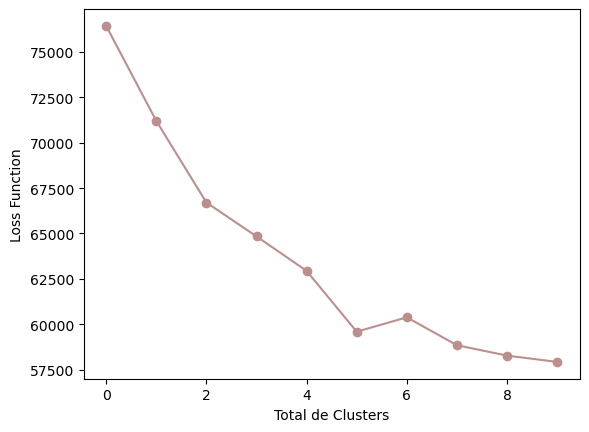

In [7]:
inertias = []

K_range = range(1, 11)
for i in K_range:
    pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=i, random_state = 42))
    ])
    pipeline.fit(df)
    inertias.append(pipeline.named_steps['kmeans'].inertia_)

plt.plot(inertias, marker = "o", c = "rosybrown")
plt.xlabel("Total de Clusters")
plt.ylabel("Loss Function")

#### <font color='cornflowerblue'> Análisis:

### <font color='cornflowerblue'> KMeans

In [8]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=4))
])

pipeline.fit(df)

c:\Users\arant\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=4))])

In [9]:
df['cluster'] = pipeline.predict(df)
df.groupby('cluster').mean()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,OverTime_No,OverTime_Yes
cluster,,,,,,,,,,,,,,,,,,,,,
0,35.150376,0.220551,800.052632,9.388471,2.912281,2.679198,65.192982,2.696742,2.035088,5911.969925,...,0.000000,0.000000,0.786967,0.20802,0.195489,0.453634,0.350877,1.0,0.709273,0.290727
1,34.910924,0.102521,798.887395,9.065546,2.852101,2.699160,66.529412,2.749580,1.522689,4219.721008,...,0.000000,0.326050,0.000000,0.00000,0.231933,0.433613,0.334454,1.0,1.000000,0.000000
2,46.074074,0.057613,811.707819,8.897119,3.082305,2.699588,66.037037,2.724280,3.954733,15191.242798,...,0.325103,0.004115,0.049383,0.00000,0.238683,0.514403,0.246914,1.0,0.724280,0.275720
3,35.557940,0.317597,806.223176,9.489270,2.892704,2.875536,65.304721,2.742489,1.523605,4284.236052,...,0.004292,0.416309,0.000000,0.00000,0.227468,0.467811,0.304721,1.0,0.000000,1.000000


ANALISIS  

## <font color='cornflowerblue'> LightGBM con Variables

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
model = LGBMClassifier(
    n_estimators=100_000,
    num_leaves=10,
    learning_rate=0.1,
    max_depth=6,
    lambda_l2=0.1,
    subsample=0.8,
    feature_fraction=0.8,
    verbosity=-1
)

model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
          eval_metric='auc',
          callbacks=[early_stopping(40),
                     log_evaluation(100)])

predicciones_lgbm = model.predict_proba(X_test)[:,1]
auc_lgbm = roc_auc_score(y_test, predicciones_lgbm)

Training until validation scores don't improve for 40 rounds
[100]	training's auc: 0.997795	training's binary_logloss: 0.117939	valid_1's auc: 0.785923	valid_1's binary_logloss: 0.322622
Early stopping, best iteration is:
[77]	training's auc: 0.992755	training's binary_logloss: 0.147445	valid_1's auc: 0.78009	valid_1's binary_logloss: 0.322332


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

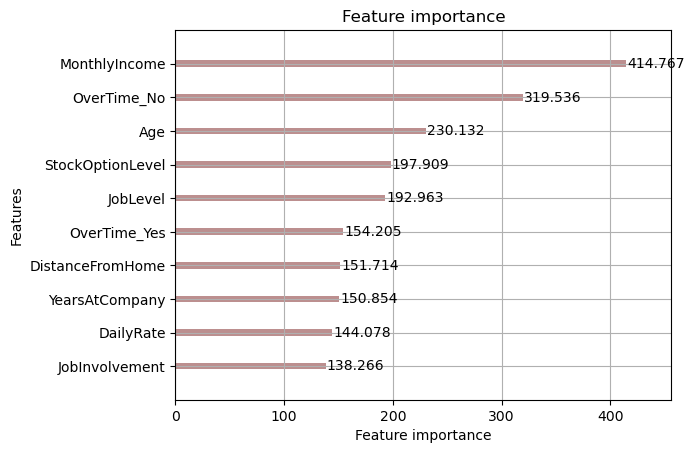

In [16]:
lgb.plot_importance(model, max_num_features = 10, importance_type='gain', color = 'rosybrown')

### <font color='cornflowerblue'> Shap Values

In [24]:
X_shap = X_test.sample(290, random_state=42)

explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_shap)

c:\Users\arant\anaconda3\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


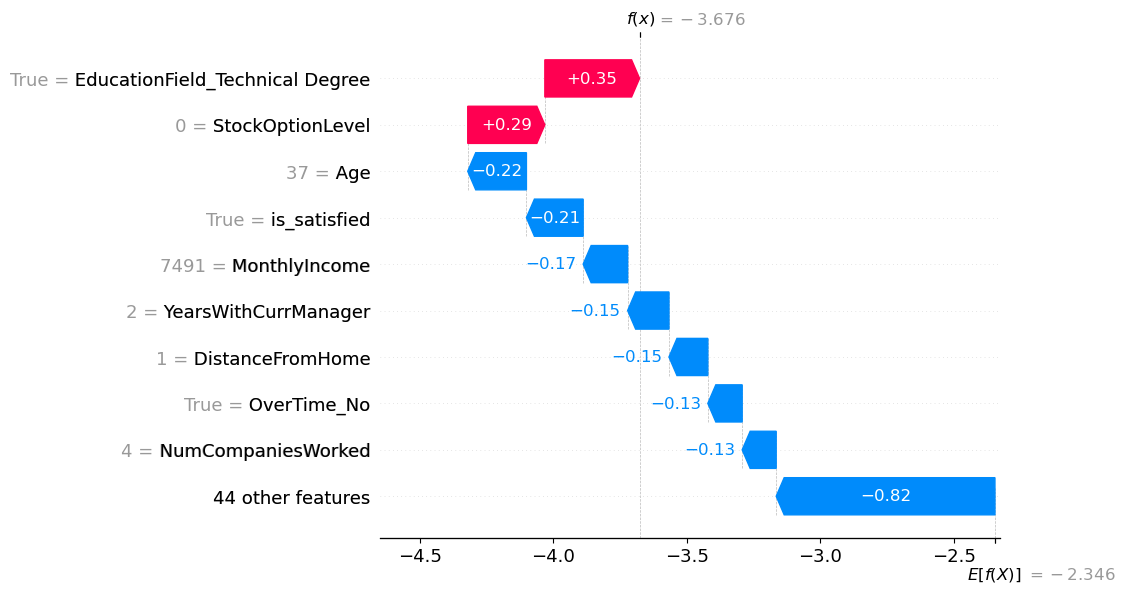

In [25]:
shap.initjs()

shap.plots.waterfall(shap.Explanation(
    values = shap_values[0],
    base_values = explainer.expected_value,
    data = X_shap.iloc[0],
    feature_names = X_shap.keys()
))

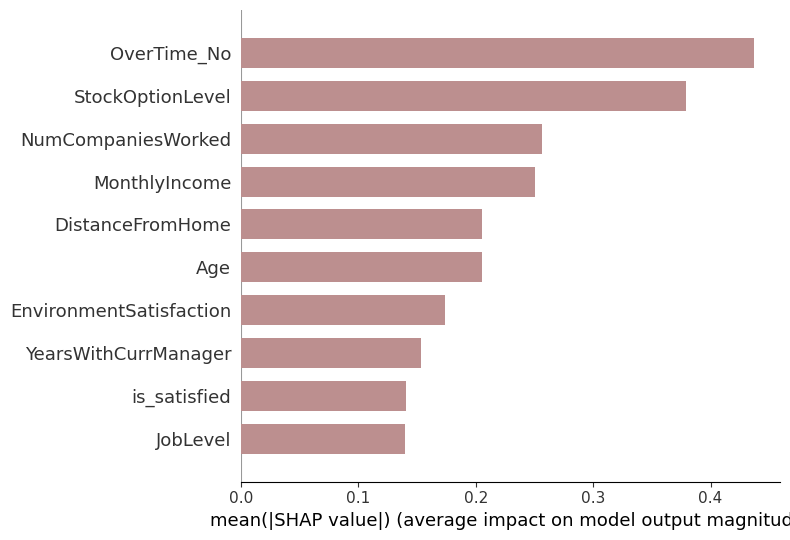

In [26]:
shap.summary_plot(shap_values, X_shap, plot_type="bar", max_display = 10, color = "rosybrown")

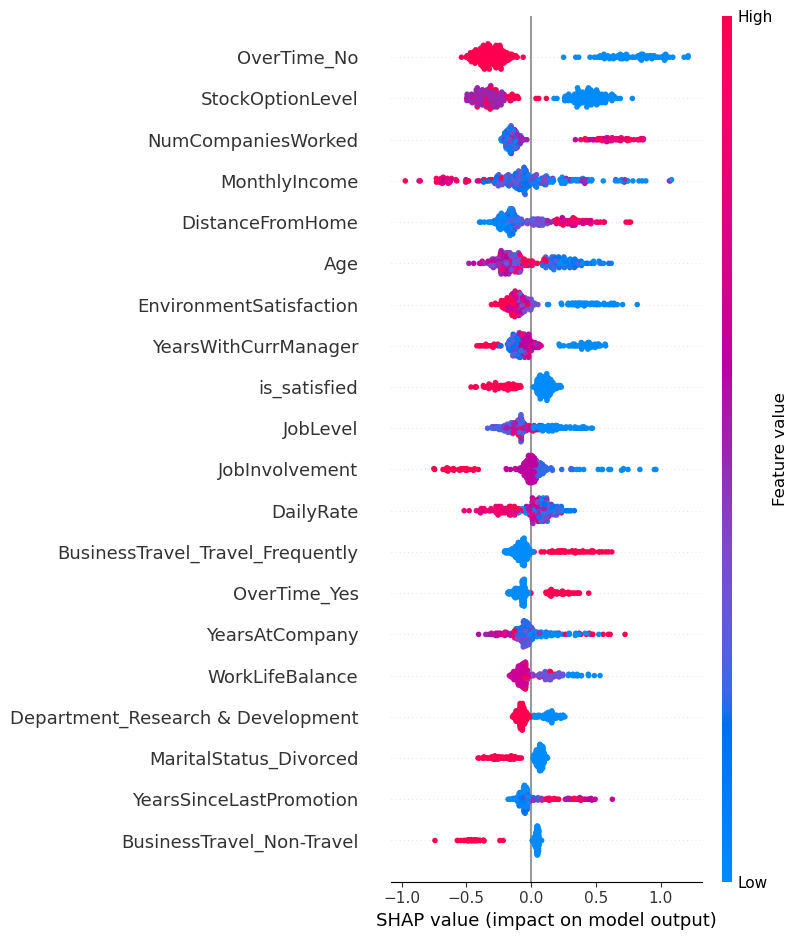

In [27]:
shap.summary_plot(shap_values, X_shap, plot_type="dot")

ANALISIS

## <font color='cornflowerblue'> LightGBM con todos los componentes

In [30]:
x_train_c = x_components.loc[X_train.index]
x_test_c = x_components.loc[X_test.index]

In [31]:
model = XGBRegressor(
    n_estimators=10_000,
    max_depth=5,
    learning_rate=0.01,
    reg_lambda=0.5,
    subsample=0.5,
    colsample_bytree=0.8,
    eval_metric='rmse',
    early_stopping_rounds=1000,
)

model.fit(x_train_c, y_train,
          eval_set=[(x_train_c, y_train), (x_test_c, y_test)],
          verbose=500)

NameError: name 'XGBRegressor' is not defined